In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchsummary import summary

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import os

/Users/venkatakrishnanvk/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 50
torch.manual_seed(seed)

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [4]:
batch_size = 32
num_workers = os.cpu_count()
num_workers

10

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307,0.3081)
])

In [6]:
full_data = MNIST(
    root = 'datasets',
    train = True,
    transform = transform,
    download = True
)
test_data = MNIST(
    root = 'datasets',
    train = False,
    transform = transform,
    download = True
)

In [7]:
train_data, val_data = random_split(full_data, [55000,5000])

In [8]:
print(len(train_data))
print(len(val_data))

55000
5000


In [9]:
train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)
val_loader = DataLoader(
    val_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)
test_loader = DataLoader(
    test_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers
)

In [10]:
# class MNISTDataModule(pl.LightningDataModule):
#     def __init__(self, data_dir="datasets", 
#                  batch_size=batch_size, num_workers=num_workers):
#         super().__init__()
#         self.data_dir = data_dir
#         self.batch_size = batch_size
#         self.num_workers = num_workers

#         self.transform = transforms.Compose(
#             [
#                 transforms.ToTensor(),
#                 transforms.Normalize((0.1307,), (0.3081,)),
#             ]
#         )

#     def prepare_data(self):
#         MNIST(self.data_dir, train=True, download=True)
#         MNIST(self.data_dir, train=False, download=True)

#     def setup(self, stage=None):
#         # Assign train/val datasets
#         if stage == "fit" or stage is None:
#             mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
#             self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
            
#             # new_data = []
#             # for i in self.mnist_train:
#             #     images, labels = i
#             #     if labels == 3:
#             #         new_data.append(i)
#             # self.mnist_train = new_data

#             # new_data = []
#             # for i in self.mnist_val:
#             #     images, labels = i
#             #     if labels == 3:
#             #         new_data.append(i)
#             # self.mnist_val = new_data


#         # Assign test dataset
#         if stage == "test" or stage is None:
#             self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
            
#             # new_data = []
#             # for i in self.mnist_test:
#             #     images, labels = i
#             #     if labels == 3:
#             #         new_data.append(i)
#             # self.mnist_test = new_data

#     def train_dataloader(self):
#         return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

#     def val_dataloader(self):
#         return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

#     def test_dataloader(self):
#         return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [11]:
# Detective: Detects fake or real --> 1 output [0,1]
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        # self.norm = nn.BatchNorm2d(1) # NOT to be applied at the START of DISCRIMINATOR
        self.conv1 = nn.Conv2d(1, 16, 5) # 1, 28, 28 --> 16, 24, 24
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5) # 16, 24, 24 --> 32, 20, 20
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 5) # 32, 20, 20 --> 64, 16, 16
        self.norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 5, 2) # 64, 16, 16 --> 128, 6, 6
        self.norm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, 3) # 128, 6, 6 --> 128, 4, 4
        self.norm5 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128*4*4, 200)
        self.norm6 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200,1)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.norm1(self.conv1(x)))
        x = nn.functional.leaky_relu(self.norm2(self.conv2(x)))
        x = nn.functional.leaky_relu(self.norm3(self.conv3(x)))
        x = nn.functional.leaky_relu(self.norm4(self.conv4(x)))
        x = nn.functional.leaky_relu(self.norm5(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.leaky_relu(self.norm6(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

In [12]:
# Generate Fake Data: Output like real data [1, 28, 28] and values between [-1, 1]
class Generator(nn.Module):
    def __init__(self, latent_dim) -> None: # latent spze - random noise vector input
        super(Generator, self).__init__()
        self.lin1 = nn.Linear(latent_dim, 128*6*6)
        self.norm1 = nn.BatchNorm1d(128*6*6)
        # self.convT0 = nn.ConvTranspose2d(128, 128, 5, 1, 'same')
        # self.norm2 = nn.BatchNorm2d(128)

        # AVOID STRIDING AT ALL COSTS IN ConvTranspose2d
        self.convT1 = nn.ConvTranspose2d(128, 128, 5)
        self.norm2 = nn.BatchNorm2d(128)
        self.convT2 = nn.ConvTranspose2d(128, 64, 5)
        self.norm3 = nn.BatchNorm2d(64)
        self.convT3 = nn.ConvTranspose2d(64, 64, 5)
        self.norm4 = nn.BatchNorm2d(64)
        self.convT4 = nn.ConvTranspose2d(64, 32, 3)
        self.norm5 = nn.BatchNorm2d(32)
        self.convT5 = nn.ConvTranspose2d(32, 32, 3)
        self.norm6 = nn.BatchNorm2d(32)
        self.convT6 = nn.ConvTranspose2d(32, 16, 3)
        self.norm7 = nn.BatchNorm2d(16)
        self.convT7 = nn.ConvTranspose2d(16, 16, 3)
        self.norm8 = nn.BatchNorm2d(16)
        self.convT8 = nn.ConvTranspose2d(16, 1, 3)
        self.norm9 = nn.BatchNorm2d(1) # NOT to be applied at the END of GENERATOR

    def forward(self, x):
        # Pass the latent space into the linear layer and reshape
        x = torch.relu(self.norm1(self.lin1(x)))
        x = x.view(-1, 128, 6, 6)

        # Upsampling begins
        # x = torch.relu(self.norm2(self.convT0(x)))
        x = torch.relu(self.norm2(self.convT1(x)))
        x = torch.relu(self.norm3(self.convT2(x)))
        x = torch.relu(self.norm4(self.convT3(x)))
        x = torch.relu(self.norm5(self.convT4(x)))
        x = torch.relu(self.norm6(self.convT5(x)))
        x = torch.relu(self.norm7(self.convT6(x)))
        x = torch.relu(self.norm8(self.convT7(x)))
        x = torch.tanh(self.norm9(self.convT8(x)))

        return(x)

In [13]:
discriminator = Discriminator()
summary(discriminator, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
       BatchNorm2d-2           [-1, 16, 24, 24]              32
            Conv2d-3           [-1, 32, 20, 20]          12,832
       BatchNorm2d-4           [-1, 32, 20, 20]              64
            Conv2d-5           [-1, 64, 16, 16]          51,264
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7            [-1, 128, 6, 6]         204,928
       BatchNorm2d-8            [-1, 128, 6, 6]             256
            Conv2d-9            [-1, 128, 4, 4]         147,584
      BatchNorm2d-10            [-1, 128, 4, 4]             256
           Linear-11                  [-1, 200]         409,800
      BatchNorm1d-12                  [-1, 200]             400
           Linear-13                    [-1, 1]             201
Total params: 828,161
Trainable params:

In [14]:
generator = Generator(10)
summary(generator, (10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4608]          50,688
       BatchNorm1d-2                 [-1, 4608]           9,216
   ConvTranspose2d-3          [-1, 128, 10, 10]         409,728
       BatchNorm2d-4          [-1, 128, 10, 10]             256
   ConvTranspose2d-5           [-1, 64, 14, 14]         204,864
       BatchNorm2d-6           [-1, 64, 14, 14]             128
   ConvTranspose2d-7           [-1, 64, 18, 18]         102,464
       BatchNorm2d-8           [-1, 64, 18, 18]             128
   ConvTranspose2d-9           [-1, 32, 20, 20]          18,464
      BatchNorm2d-10           [-1, 32, 20, 20]              64
  ConvTranspose2d-11           [-1, 32, 22, 22]           9,248
      BatchNorm2d-12           [-1, 32, 22, 22]              64
  ConvTranspose2d-13           [-1, 16, 24, 24]           4,624
      BatchNorm2d-14           [-1, 16,

# GAN Model

In [15]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim = 256, lr = 1e-3) -> None:
        super(GAN, self).__init__()
        self.save_hyperparameters() # Save all the hyperparameters - will make it accessible everywhere later
        self.generator = Generator(latent_dim = self.hparams.latent_dim) # Access hyperparameters from hparams
        self.discriminator = Discriminator()

        # Random Noise for testing images
        self.validation_z = torch.randn(6, self.hparams.latent_dim, requires_grad=True)
        # 6 images with dimensions = latent_dim = 100

    def forward(self, z):
        return self.generator(z) # Only generates images
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch # We don't need labels, hence we use the _
        # real_imgs are the real images for training

        # sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim, requires_grad=True)
        z = z.type_as(real_imgs) # type_as --> Move to GPU if used else CPU

        # TRAIN GENERATOR: max log(D(G(z)))
        if optimizer_idx == 0: # Then train generator
            fake_imgs = self(z) # Exectues forward pass (executes generator) and produces fake images
            y_hat = self.discriminator(fake_imgs) # D(G(z))
            # y_hat predicts probability of fake images being real

            y = torch.ones(real_imgs.shape[0], 1) # setting 1 (real image probability) for all 6 images
            y = y.type_as(real_imgs) # y is a tensor of ones of size 6

            gen_loss = self.adversarial_loss(y_hat, y) # Binary cross entropy loss

            # EXPLANATION - 
            # BCE = - [y*log(y_hat) + (1-y)*log(1-y_hat)]
            # Since y = vector of ones
            # BCE will reduce to - log(y_hat) = - log(D(G(z))
            # ALSO: max (log(D(G(z))) = min (-log(D(G(z))))

            log_dict = {"generator_loss":gen_loss}
            return {"loss" : gen_loss, "progress bar": log_dict, "log": log_dict}
        
        # TRAIN DISCRIMINATOR: max log(D(x)) + log(1 - D(G(z)))
        # where 
        # x - original images
        # z - Latent space
        # G(z) - Generated Image
        # D(G(z)) - Prediction of Realness in Generated image

        # so, if we maximise 1 - D(G(z)) 
        # => minimise D(G(z)) 
        # => ensure fake images are predicted correctly as FAKE

        if optimizer_idx == 1: # Then train discriminator
            # how well it can predict real images as real
            y_hat_real = self.discriminator(real_imgs) # Prediction of real images by the discriminator
            
            y_real = torch.ones(real_imgs.shape[0], 1) # setting 1 (real image probability) for all 6 images
            y_real = y_real.type_as(real_imgs)

            real_imgs_loss = self.adversarial_loss(y_hat_real, y_real)

            # EXPLANATION - 
            # BCE = - [y*log(y_hat) + (1-y)*log(1-y_hat)]
            # Since y = vector of ones
            # BCE will reduce to - log(y_hat) = - log(D(x))
            # ALSO: max (log(D(x)) = min (-log(D(x))

            # how well it can predict fake images as fake
            fake_imgs = self(z) # Exectues forward pass (executes generator) and produces fake images
            y_hat_fake = 1 - self.discriminator(fake_imgs.detach()) # Here .detach() in important for not linking it to z for grads

            y_fake = torch.ones(real_imgs.shape[0], 1) # or set to 0 (fake image probability) for all 6 images
            # using zeros makes binary cross entropy for D(G(z)) equivalent to 1 - D(G(z))

            # OR USE THIS
            # y_hat_fake = self.discriminator(fake_imgs.detach())
            # y_fake = torch.zeros(real_imgs.shape[0], 1)

            # EXPLANATION - 
            # BCE = - [y*log(y_hat) + (1-y)*log(1-y_hat)]
            # If y = vector of zeros
            # BCE will reduce to - log(1 - y_hat) = - log(1 - D(G(z)))
            # ALSO: max (log(1 - D(G(z))) = min (-log(1 - D(G(z)))

            y_fake = y_fake.type_as(real_imgs)

            fake_imgs_loss = self.adversarial_loss(y_hat_fake, y_fake)

            discriminator_loss = (real_imgs_loss + fake_imgs_loss)/2

            log_dict = {"discriminator_loss":discriminator_loss}
            return {"loss" : discriminator_loss, "progress bar": log_dict, "log": log_dict}

    def configure_optimizers(self):
        lr = self.hparams.lr
        optim_gen = torch.optim.SGD(self.generator.parameters(), lr = lr)
        optim_dis = torch.optim.Adam(self.discriminator.parameters(), lr = lr)

        return [optim_gen, optim_dis], [] # Second parameter for lr_scheduler

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight) # type_as --> Move to GPU if used
        sample_imgs = self(z).cpu() # Applies forward function on z (Passes through Generator)

        fig = plt.figure(figsize=(20,10))
        for i in range(sample_imgs.size(0)): # 6 images so i will iterate from 0 to 5
            plt.subplot(2, 3, i+1) # 2 rows and 3 columns
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i,0,:,:], cmap = 'gray', interpolation = 'none') # i,0,:,: since mnist has only 1 channel, we can 0 to only use the height and width of image
            plt.title(f'Generated data {i+1}')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off') # No axes for images
        plt.show()
            
    def on_epoch_end(self): # Does what you want to do after each epoch
        print(f'Epoch {self.current_epoch}')
        self.plot_imgs() # Plot images of generator

In [16]:
gan = GAN()
# dm = MNISTDataModule()

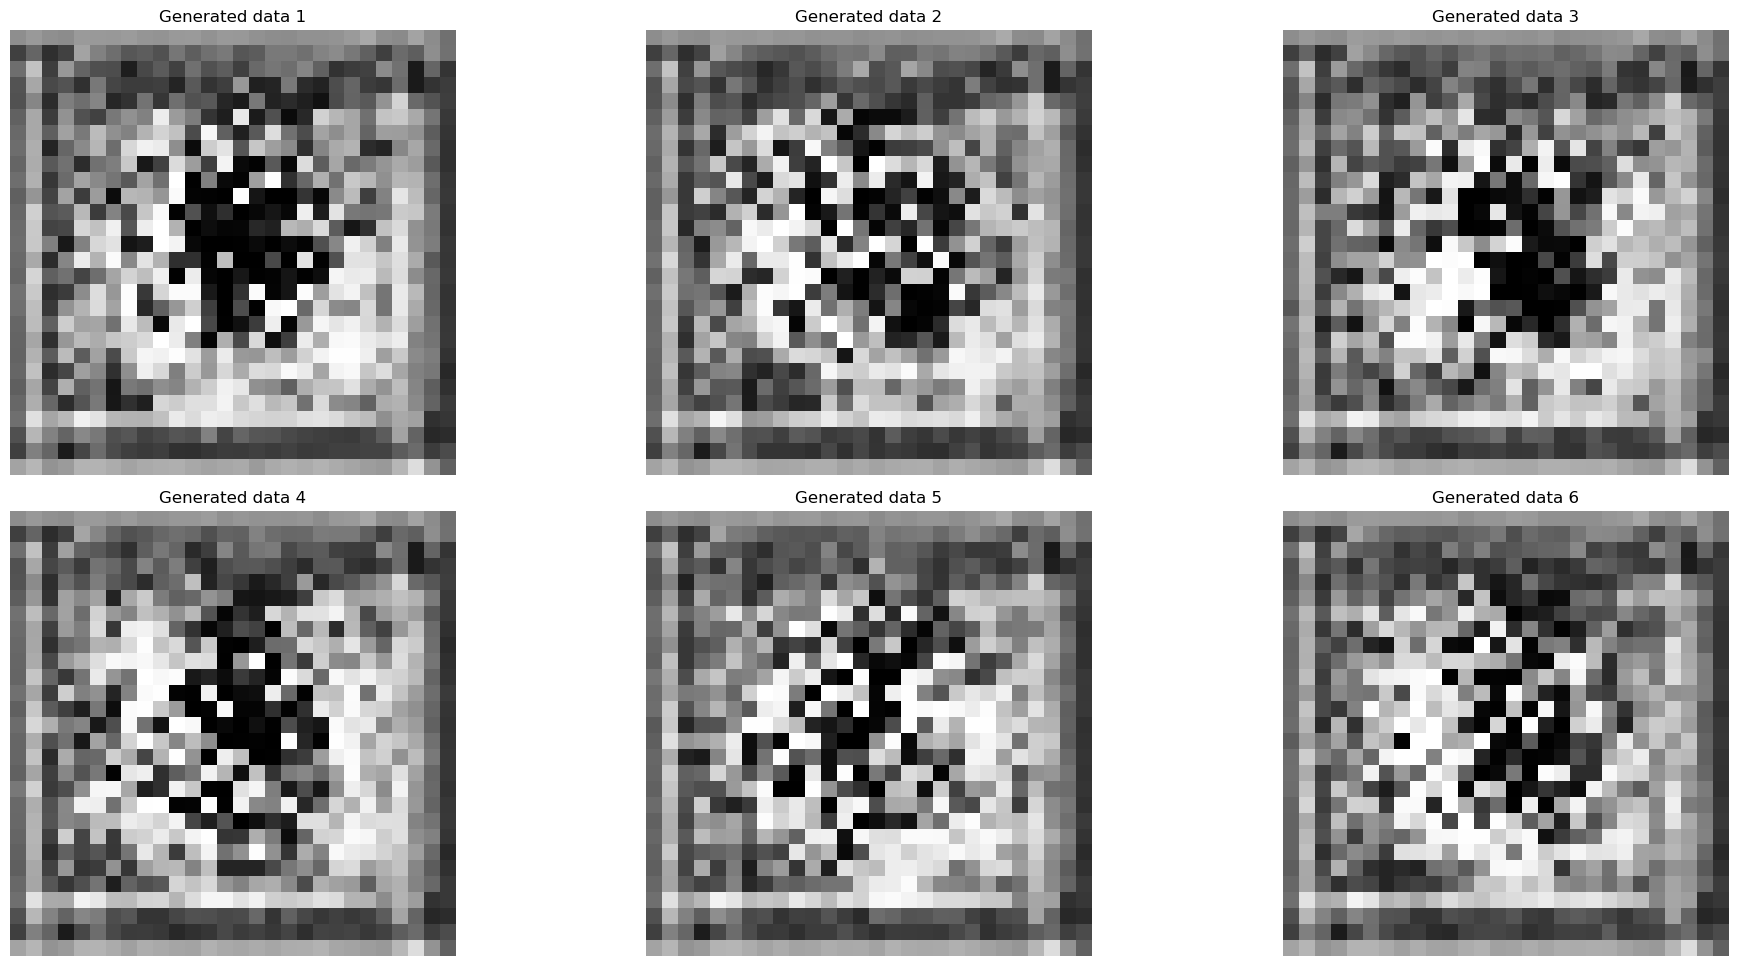

In [17]:
gan.plot_imgs()

In [18]:
summary(gan, (gan.hparams.latent_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4608]       1,184,256
       BatchNorm1d-2                 [-1, 4608]           9,216
   ConvTranspose2d-3          [-1, 128, 10, 10]         409,728
       BatchNorm2d-4          [-1, 128, 10, 10]             256
   ConvTranspose2d-5           [-1, 64, 14, 14]         204,864
       BatchNorm2d-6           [-1, 64, 14, 14]             128
   ConvTranspose2d-7           [-1, 64, 18, 18]         102,464
       BatchNorm2d-8           [-1, 64, 18, 18]             128
   ConvTranspose2d-9           [-1, 32, 20, 20]          18,464
      BatchNorm2d-10           [-1, 32, 20, 20]              64
  ConvTranspose2d-11           [-1, 32, 22, 22]           9,248
      BatchNorm2d-12           [-1, 32, 22, 22]              64
  ConvTranspose2d-13           [-1, 16, 24, 24]           4,624
      BatchNorm2d-14           [-1, 16,

/Users/venkatakrishnanvk/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/venkatakrishnanvk/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/venkatakrishnanvk/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:210: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<tra

Epoch 0: 100%|██████████| 1719/1719 [10:38<00:00,  2.69it/s, loss=2.31, v_num=5]Epoch 0


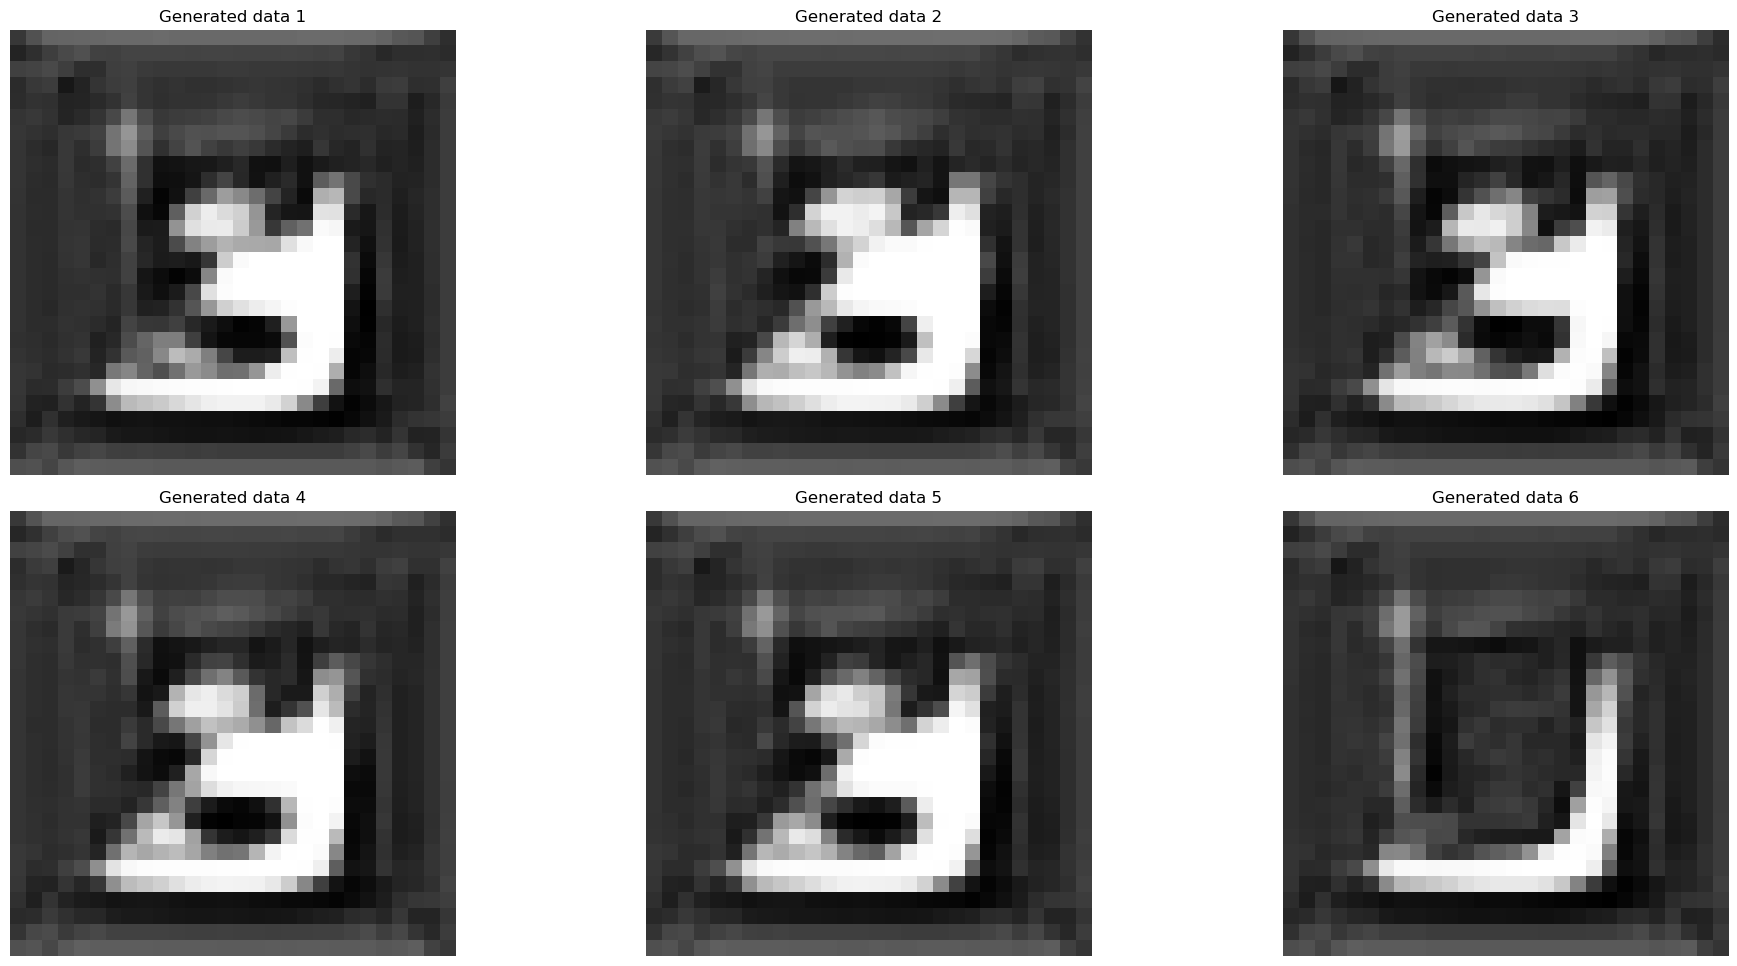

Epoch 1: 100%|██████████| 1719/1719 [10:34<00:00,  2.71it/s, loss=1.5, v_num=5] Epoch 1


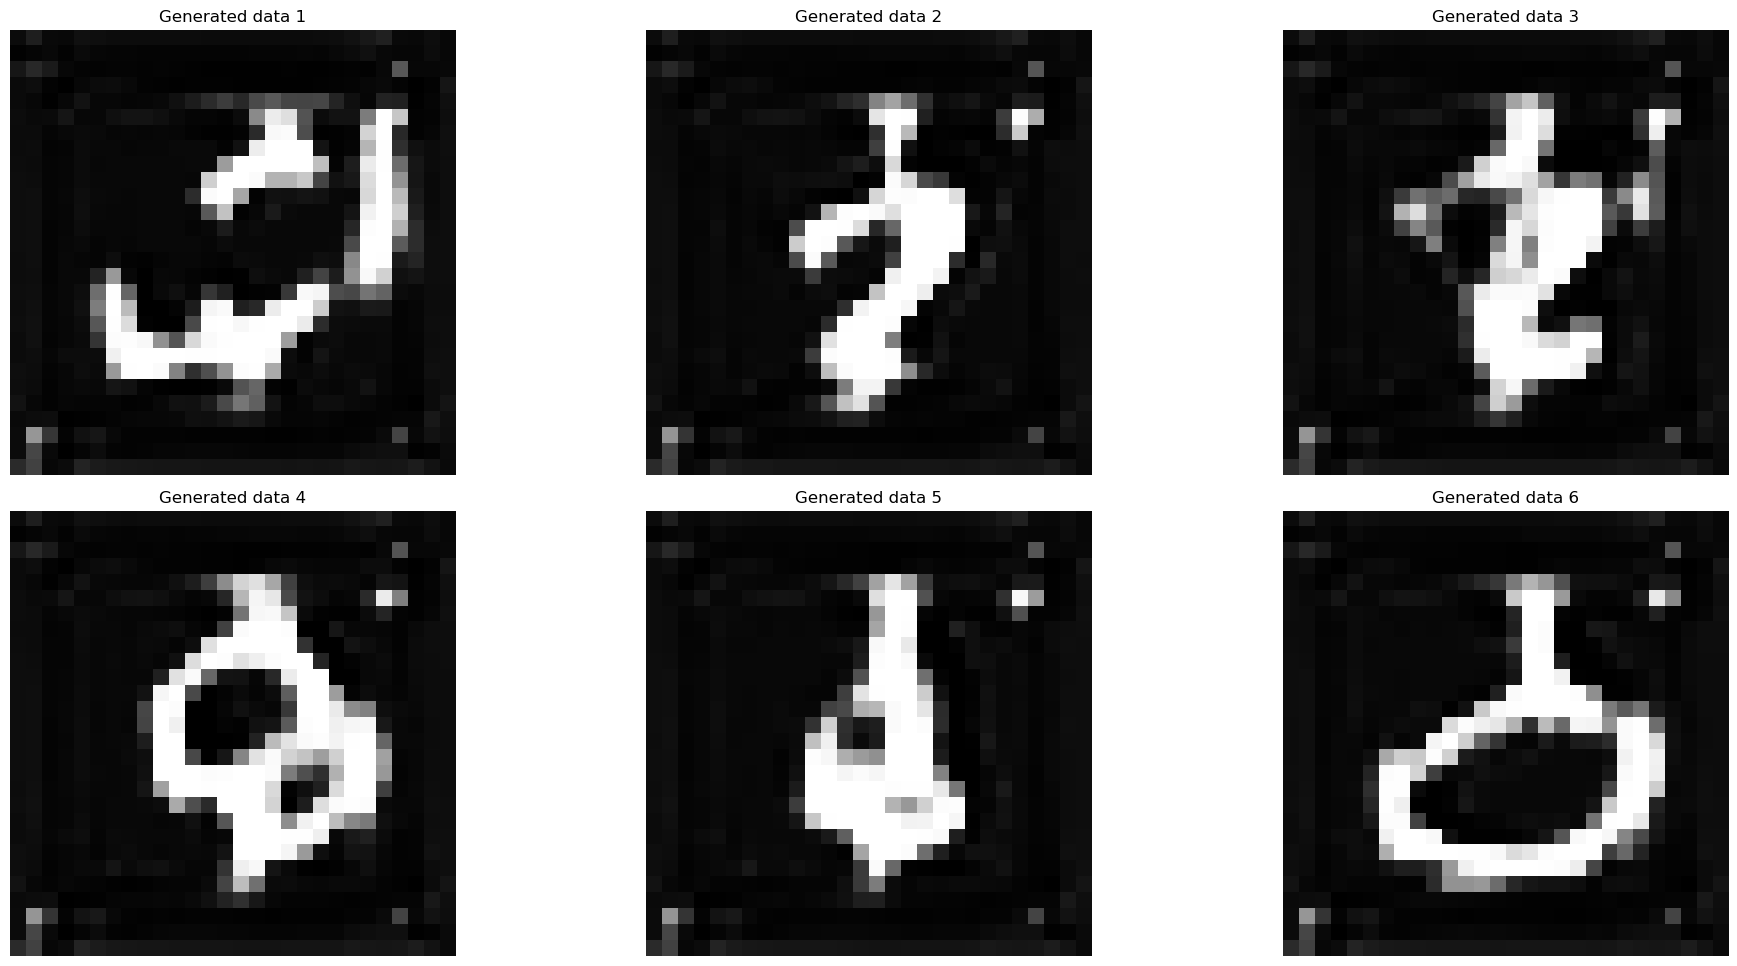

Epoch 2: 100%|██████████| 1719/1719 [10:26<00:00,  2.74it/s, loss=3.53, v_num=5]Epoch 2


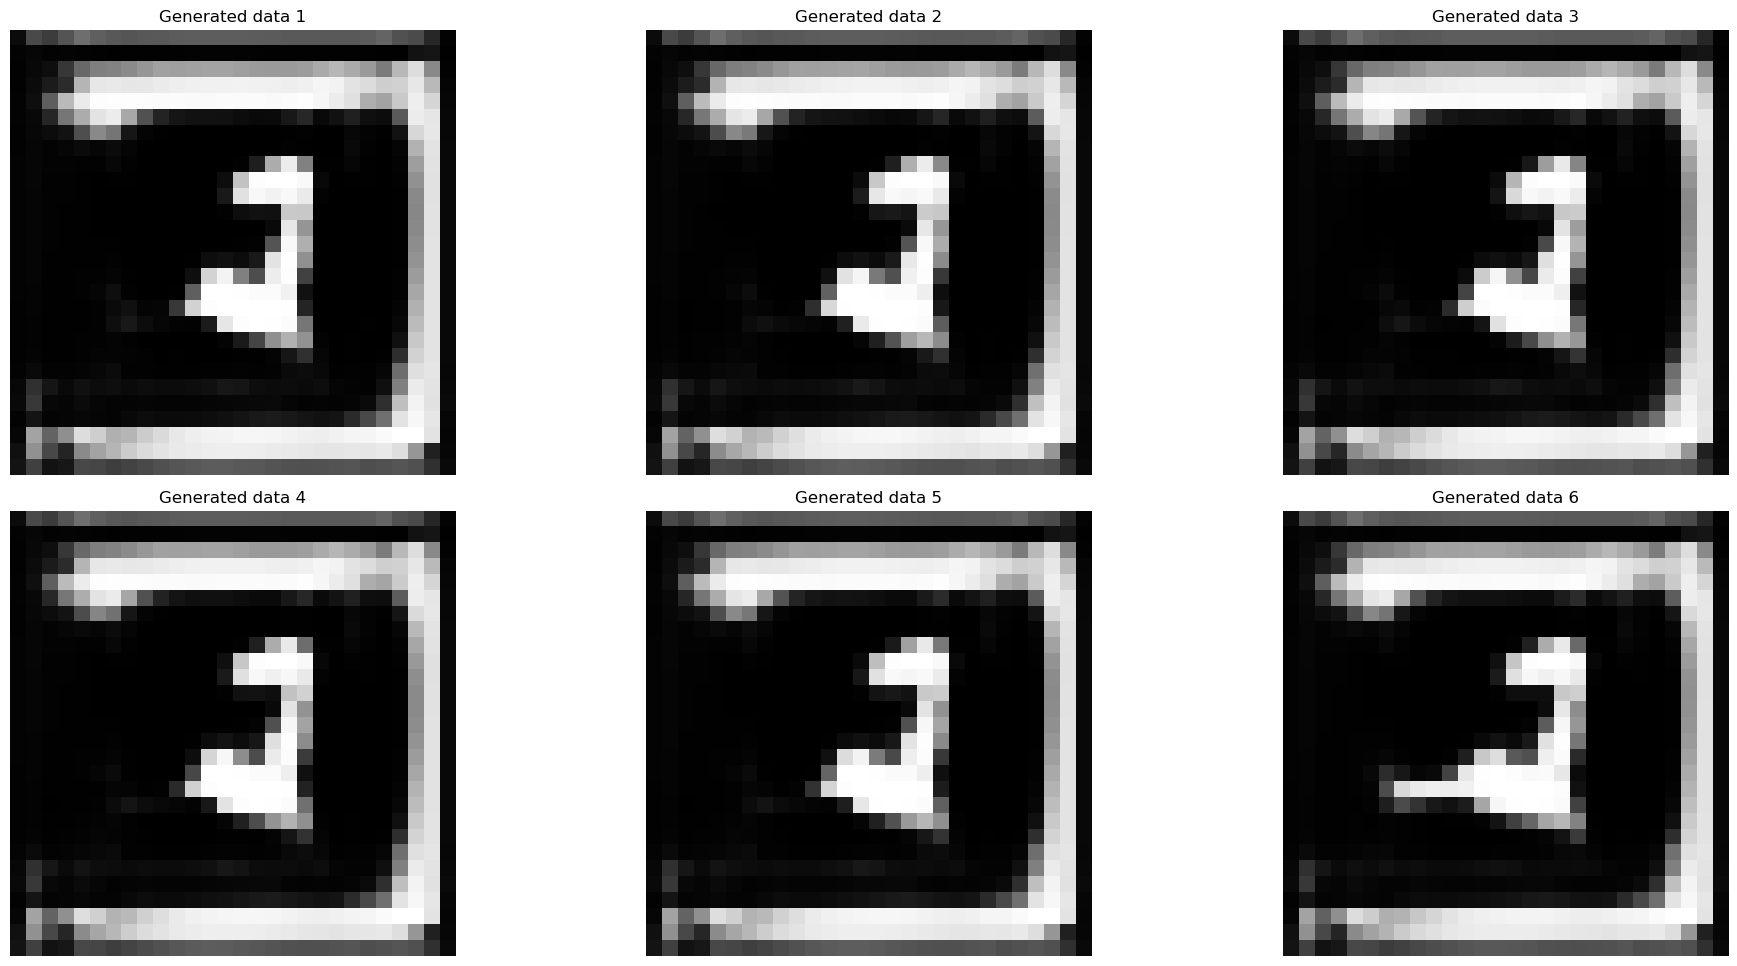

Epoch 3: 100%|██████████| 1719/1719 [10:25<00:00,  2.75it/s, loss=4.18, v_num=5]Epoch 3


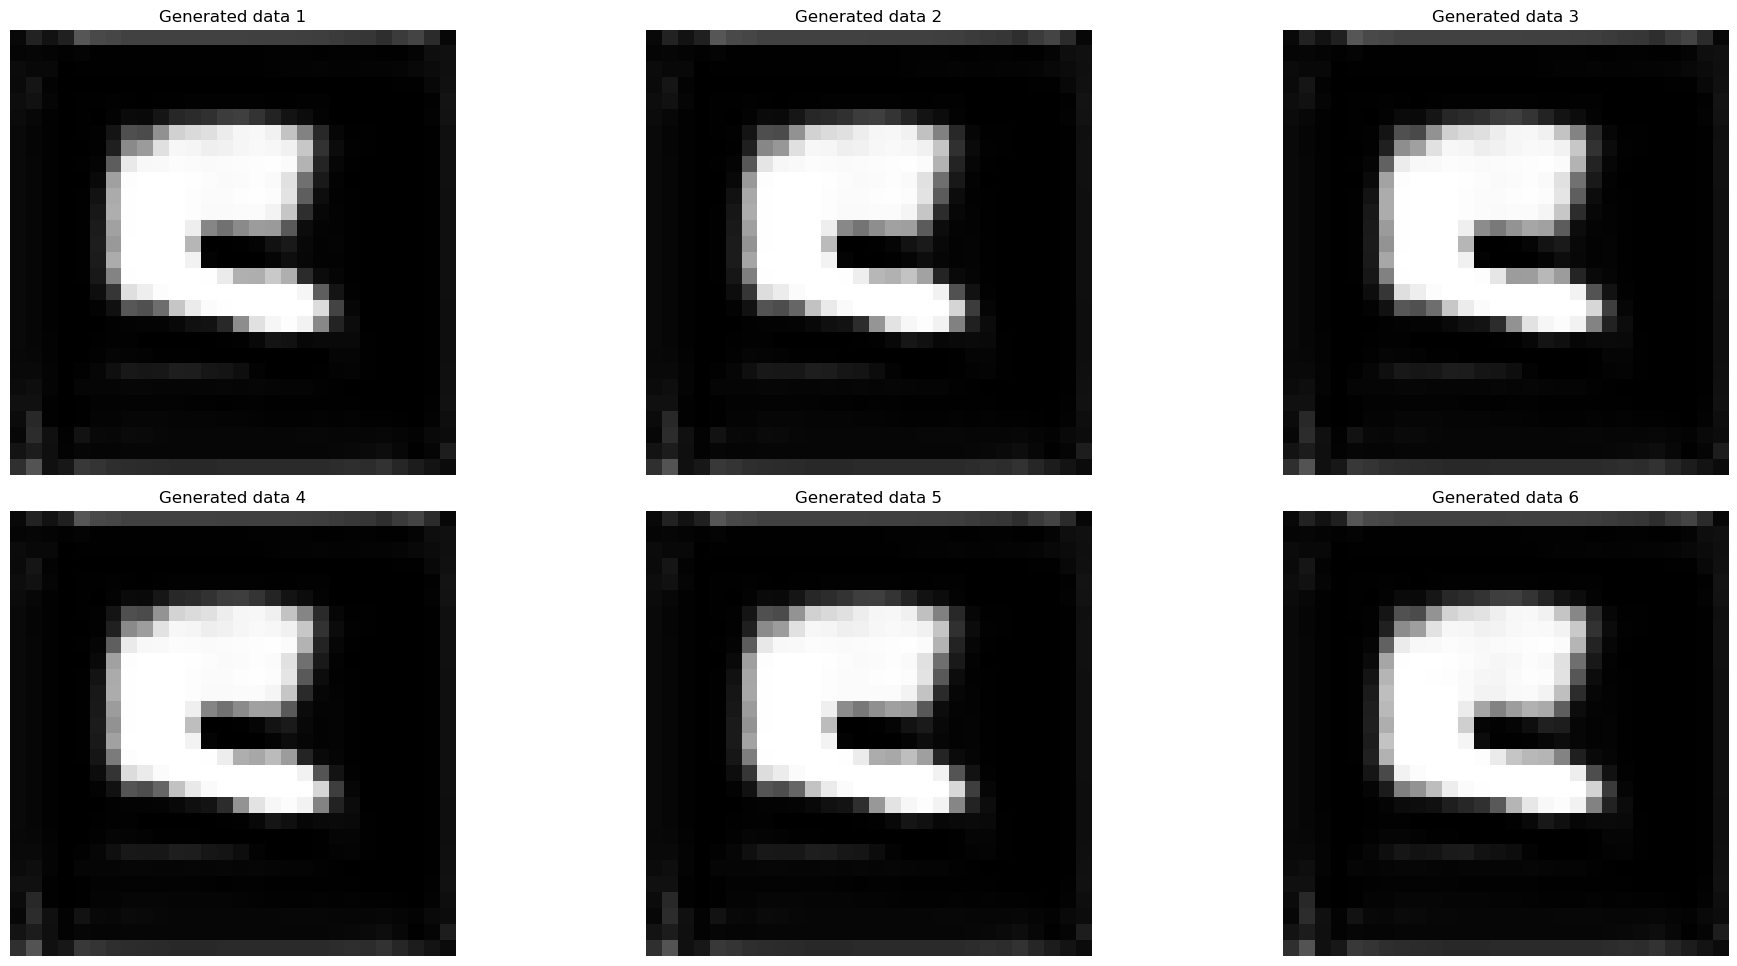

Epoch 4: 100%|██████████| 1719/1719 [10:39<00:00,  2.69it/s, loss=2.53, v_num=5]Epoch 4


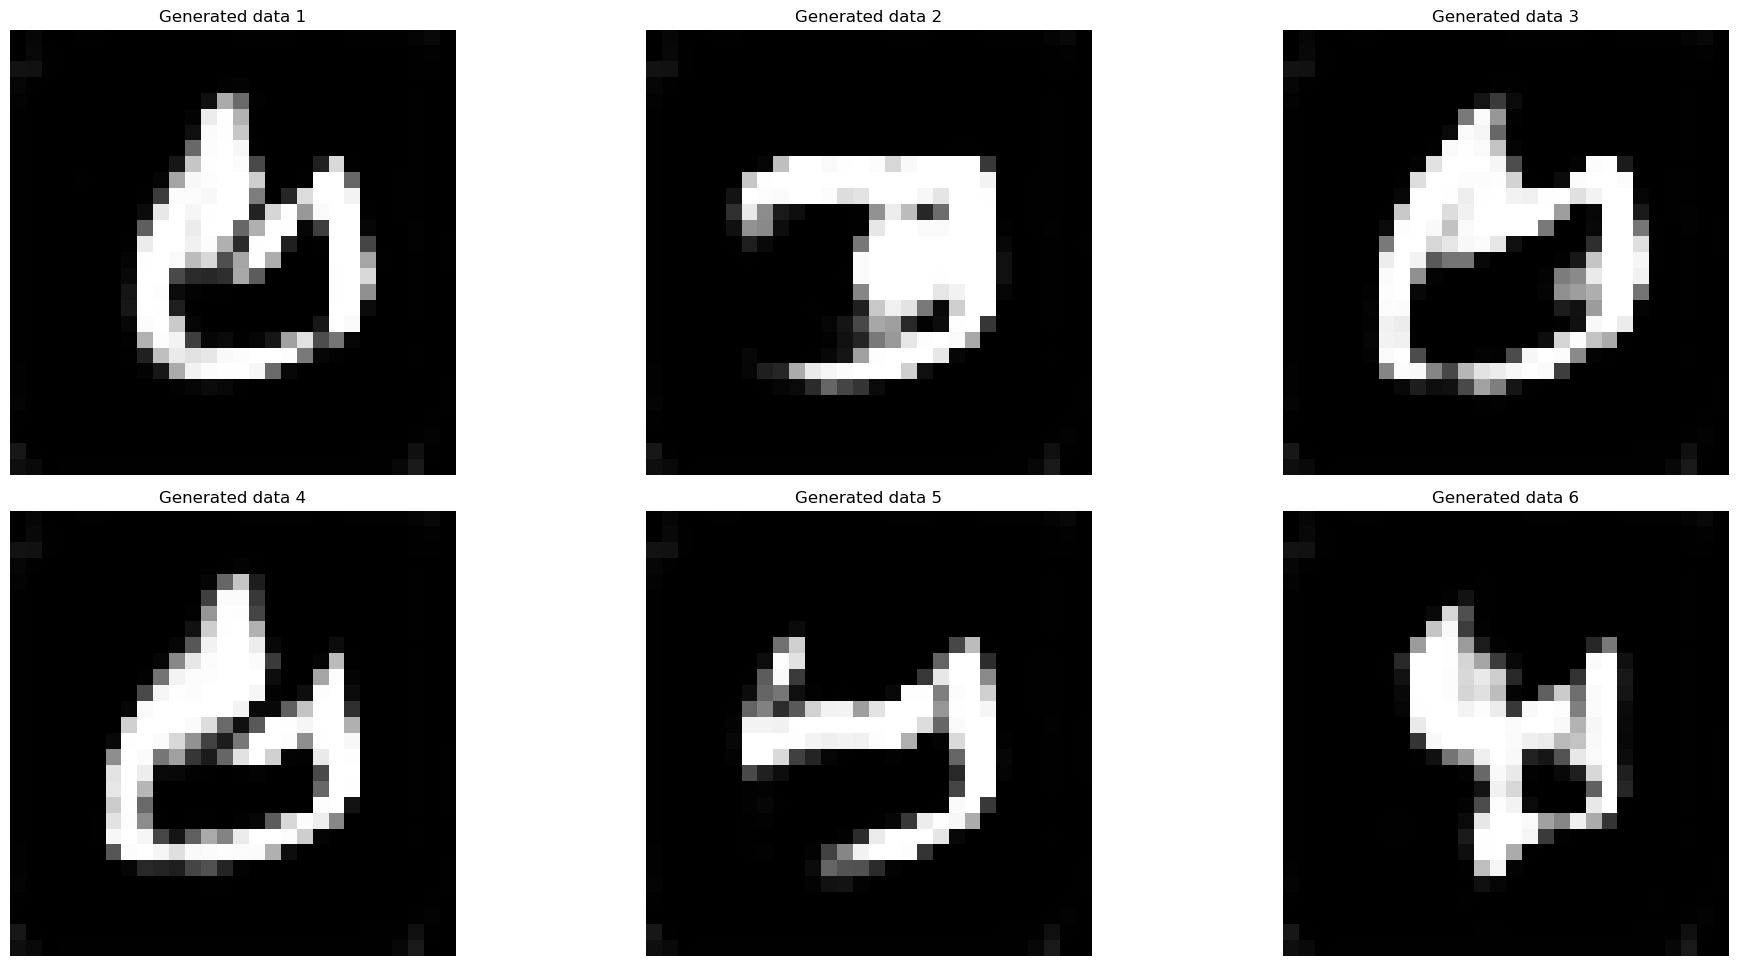

Epoch 5: 100%|██████████| 1719/1719 [10:30<00:00,  2.73it/s, loss=2.93, v_num=5]Epoch 5


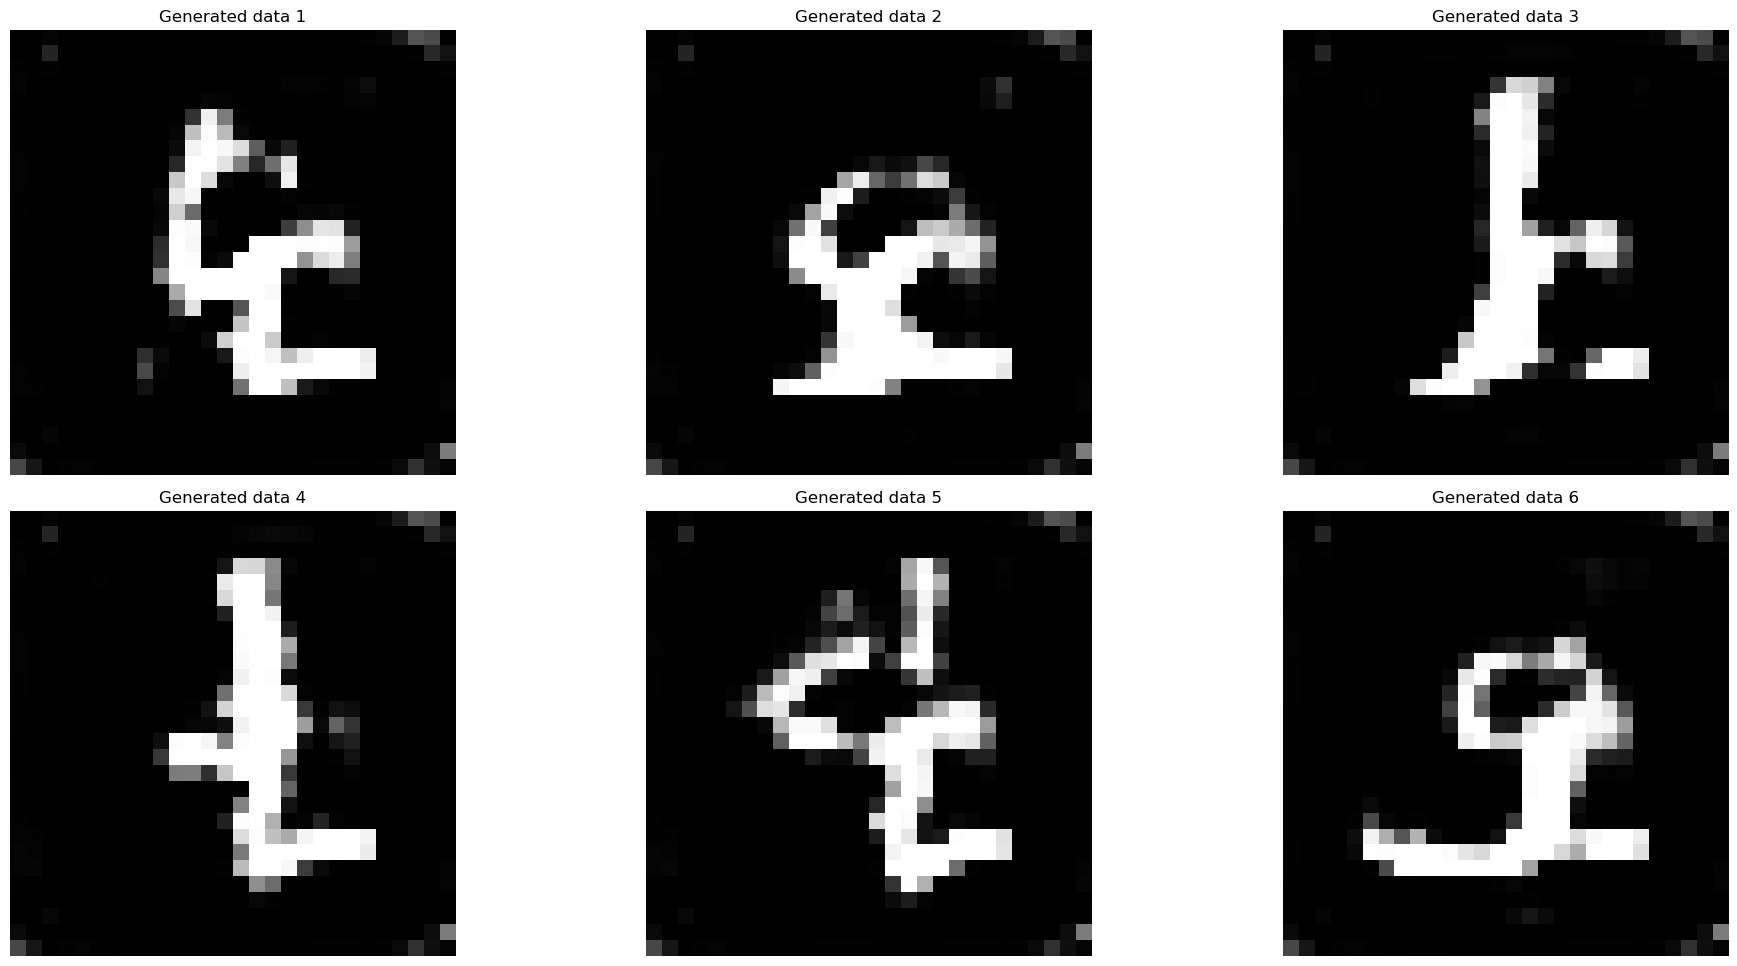

Epoch 6: 100%|██████████| 1719/1719 [10:24<00:00,  2.75it/s, loss=3.76, v_num=5]Epoch 6


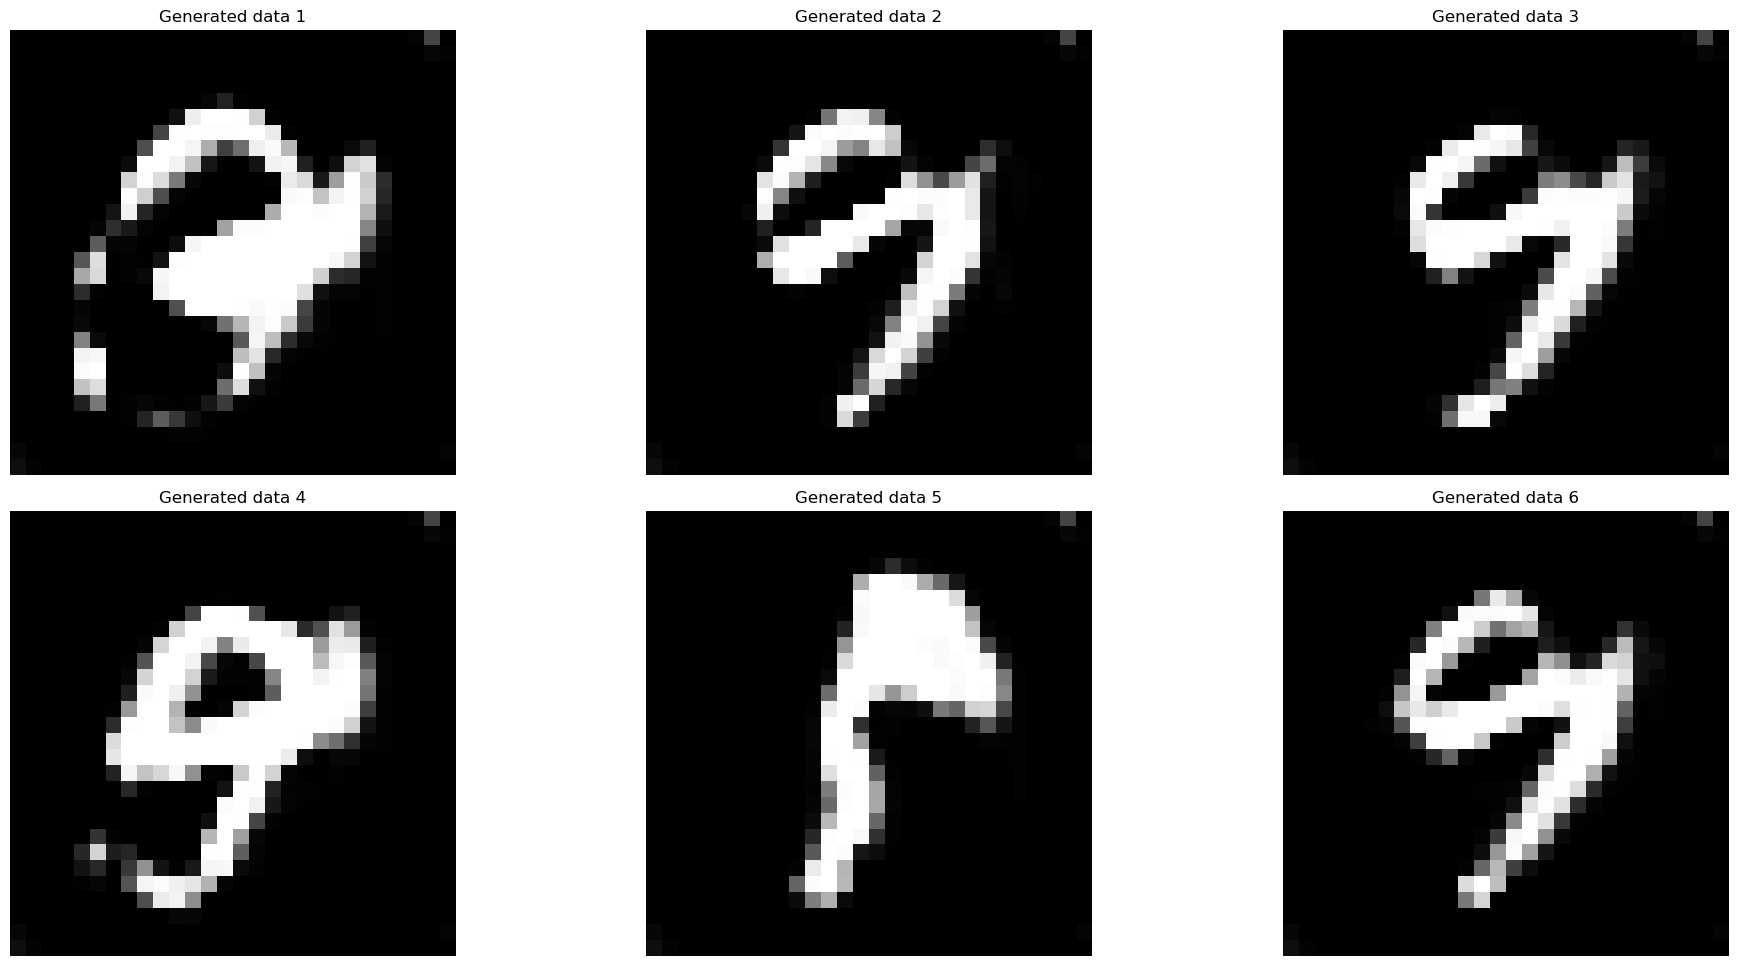

Epoch 7: 100%|██████████| 1719/1719 [10:23<00:00,  2.76it/s, loss=2.49, v_num=5]Epoch 7


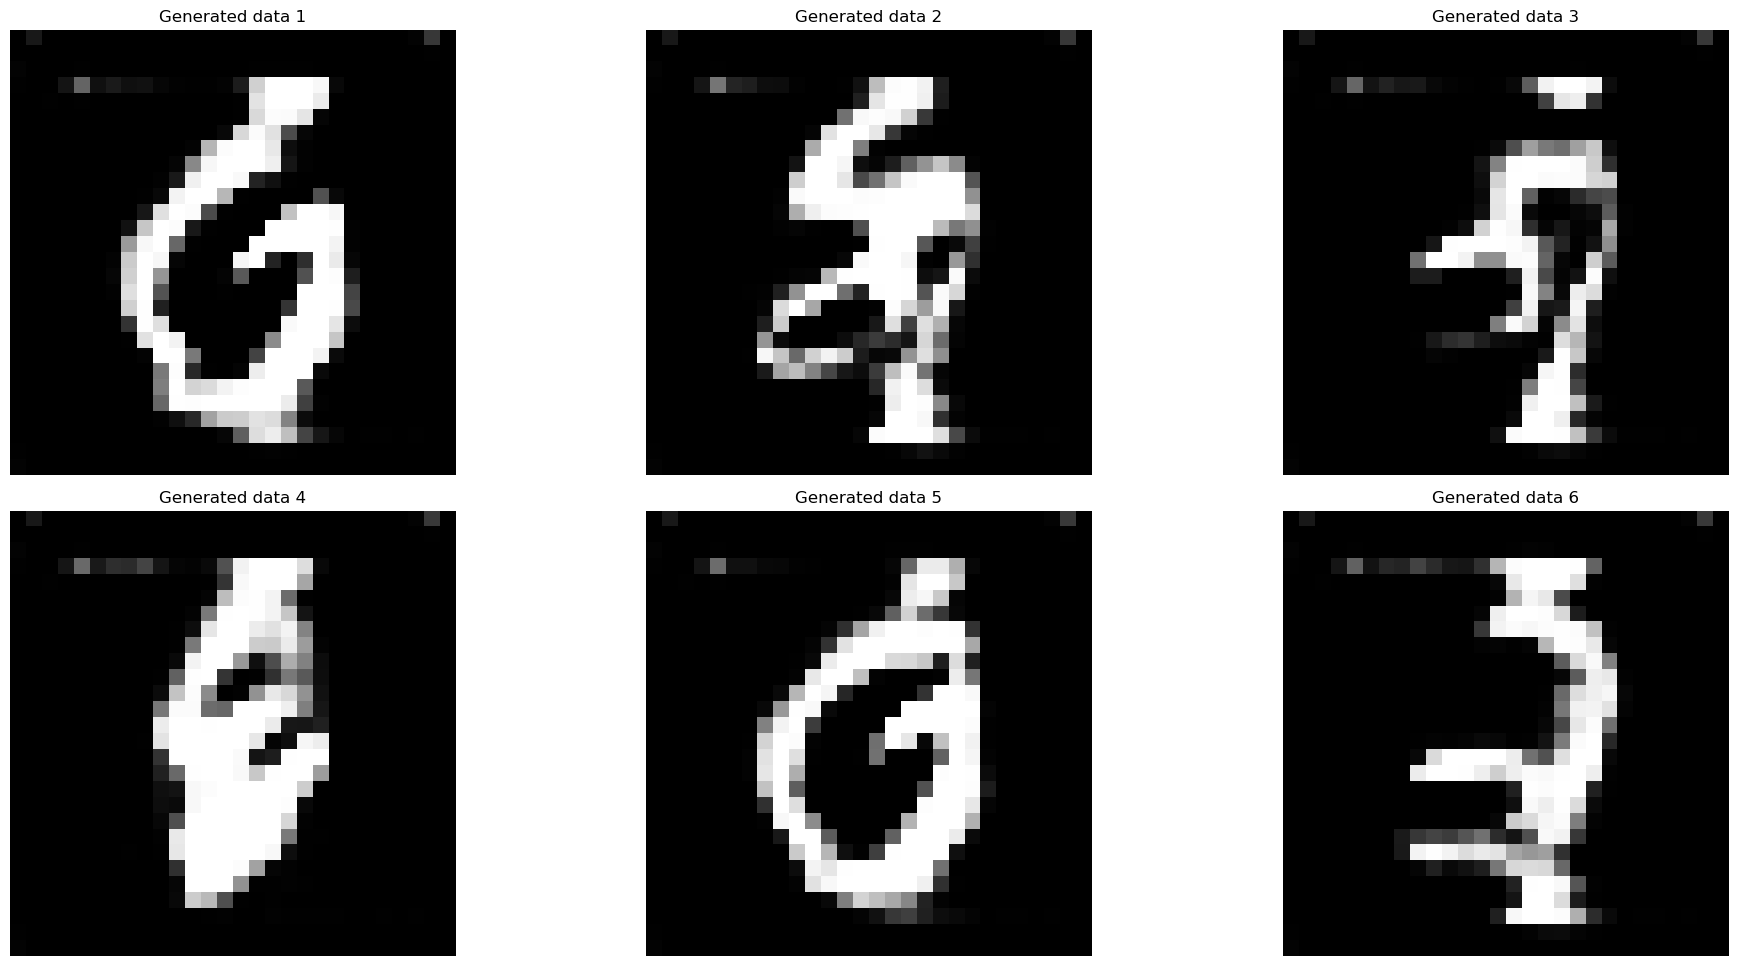

Epoch 8: 100%|██████████| 1719/1719 [10:23<00:00,  2.76it/s, loss=3.67, v_num=5]Epoch 8


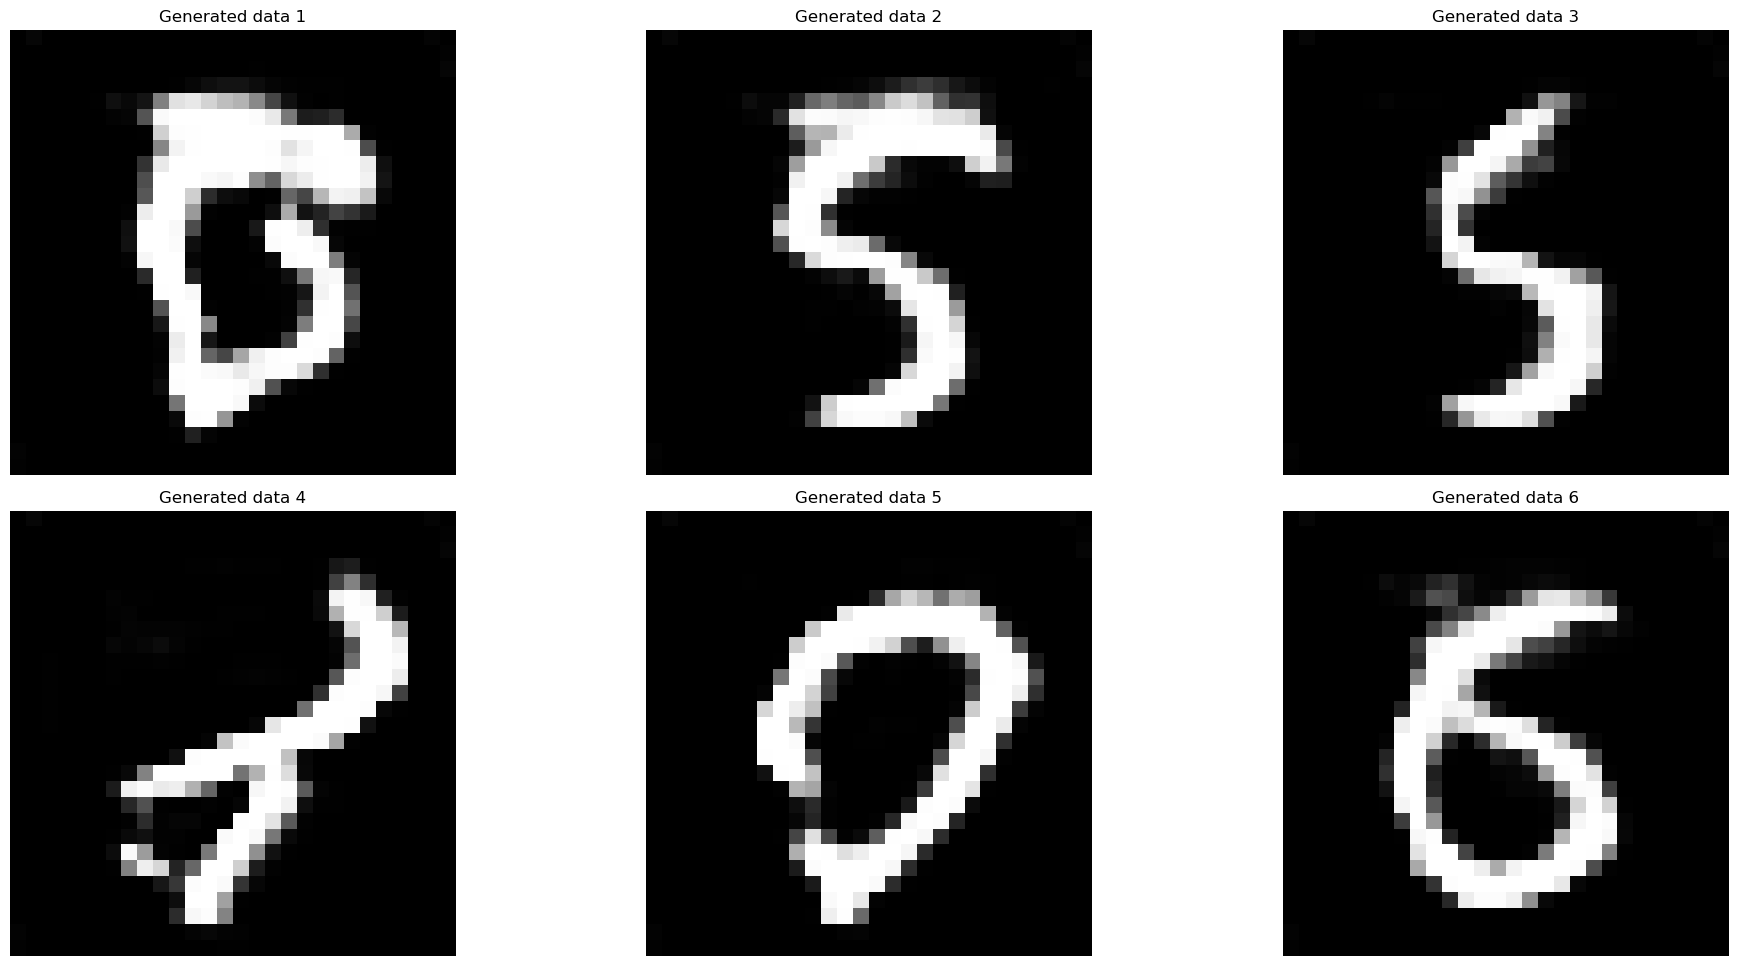

Epoch 9: 100%|██████████| 1719/1719 [10:15<00:00,  2.79it/s, loss=3.63, v_num=5]Epoch 9


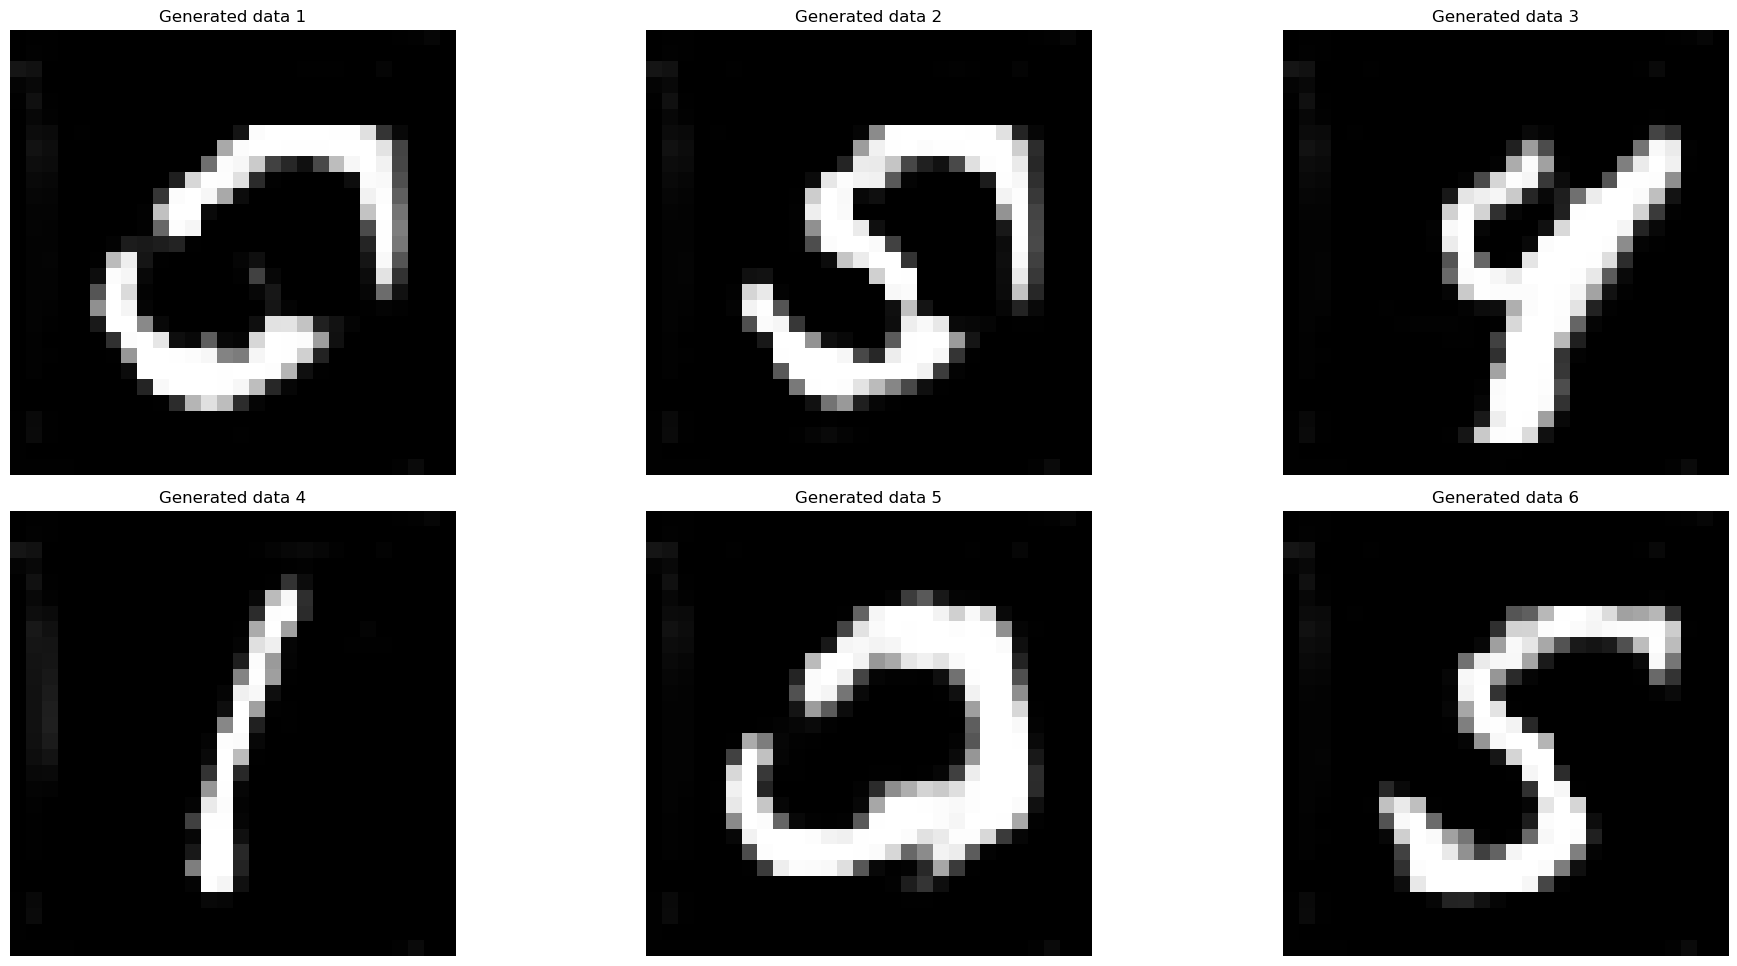

Epoch 10: 100%|██████████| 1719/1719 [10:16<00:00,  2.79it/s, loss=4.75, v_num=5]Epoch 10


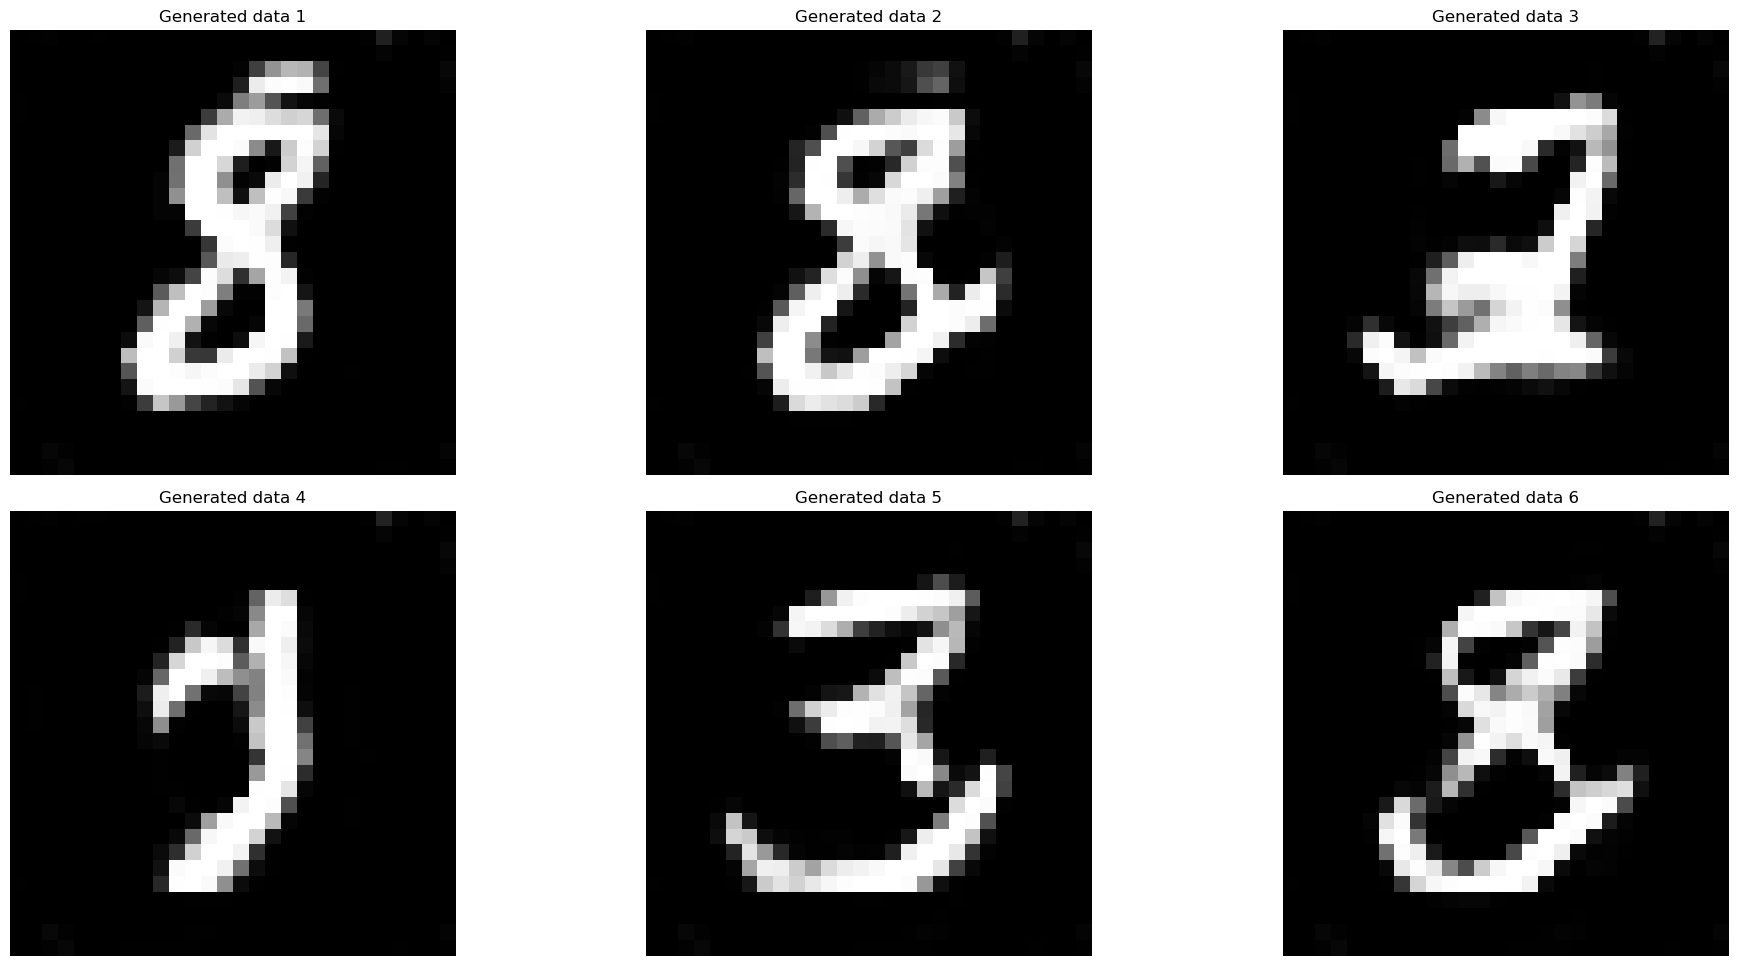

Epoch 11: 100%|██████████| 1719/1719 [10:14<00:00,  2.80it/s, loss=2.87, v_num=5]Epoch 11


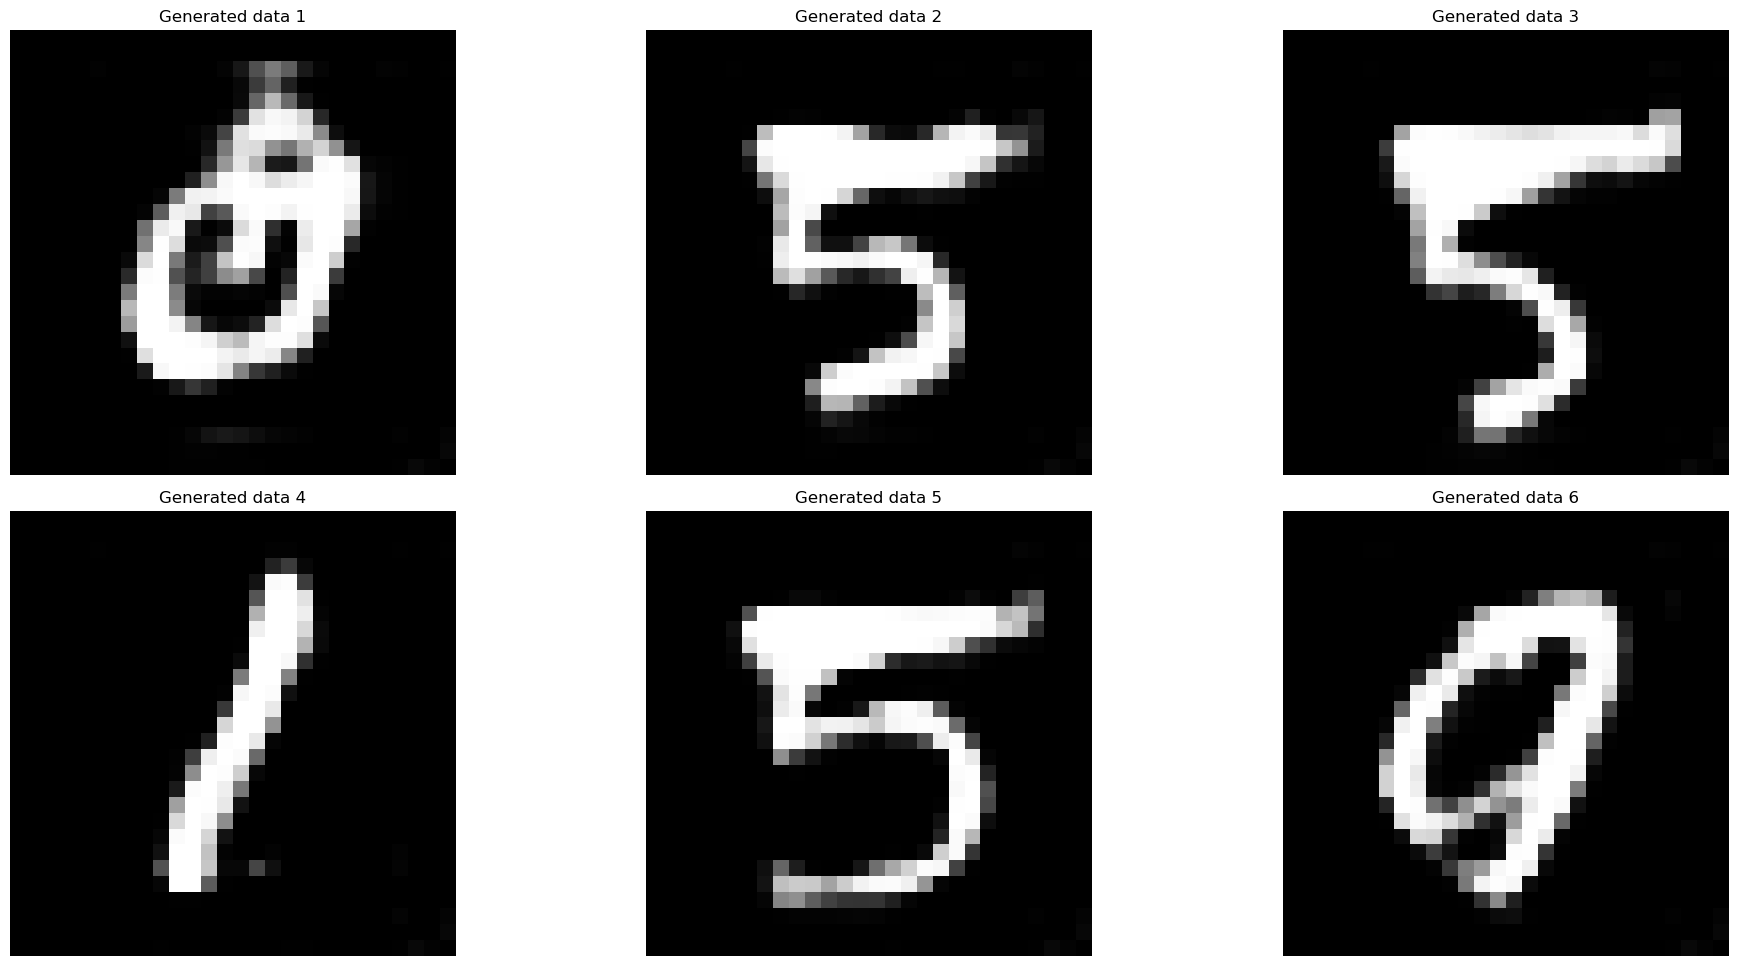

Epoch 12: 100%|██████████| 1719/1719 [10:34<00:00,  2.71it/s, loss=2.96, v_num=5]Epoch 12


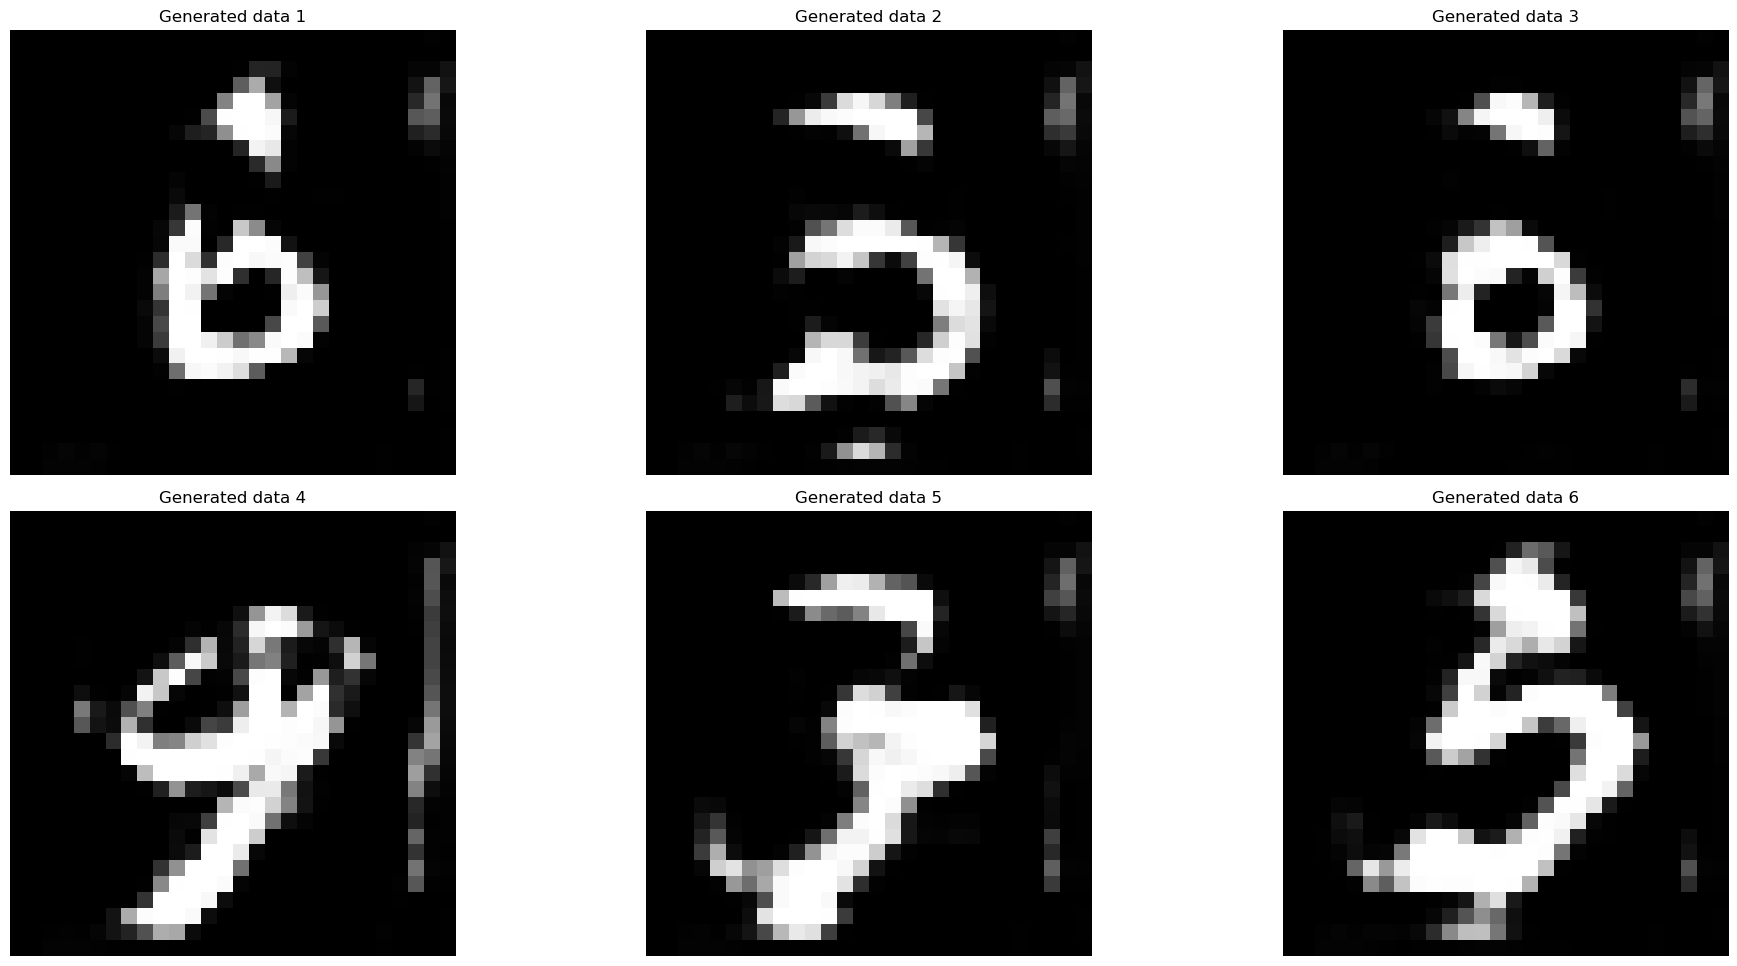

Epoch 13: 100%|██████████| 1719/1719 [10:32<00:00,  2.72it/s, loss=4.99, v_num=5]Epoch 13


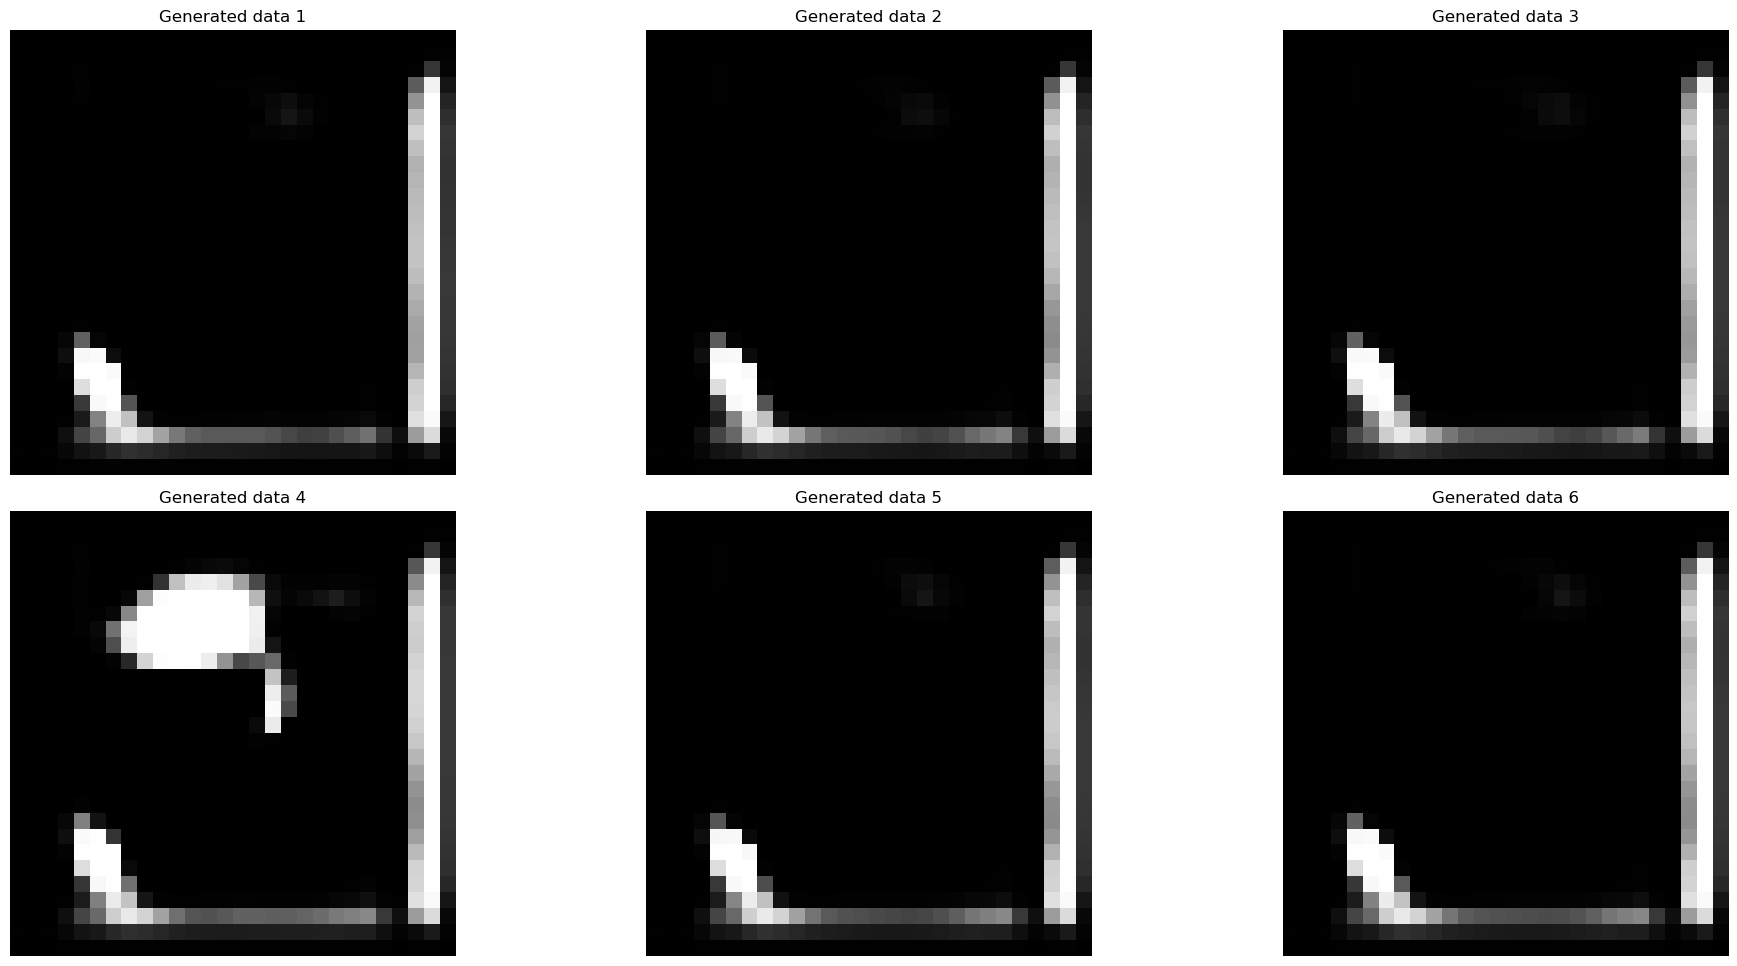

Epoch 14: 100%|██████████| 1719/1719 [10:31<00:00,  2.72it/s, loss=6.23, v_num=5]Epoch 14


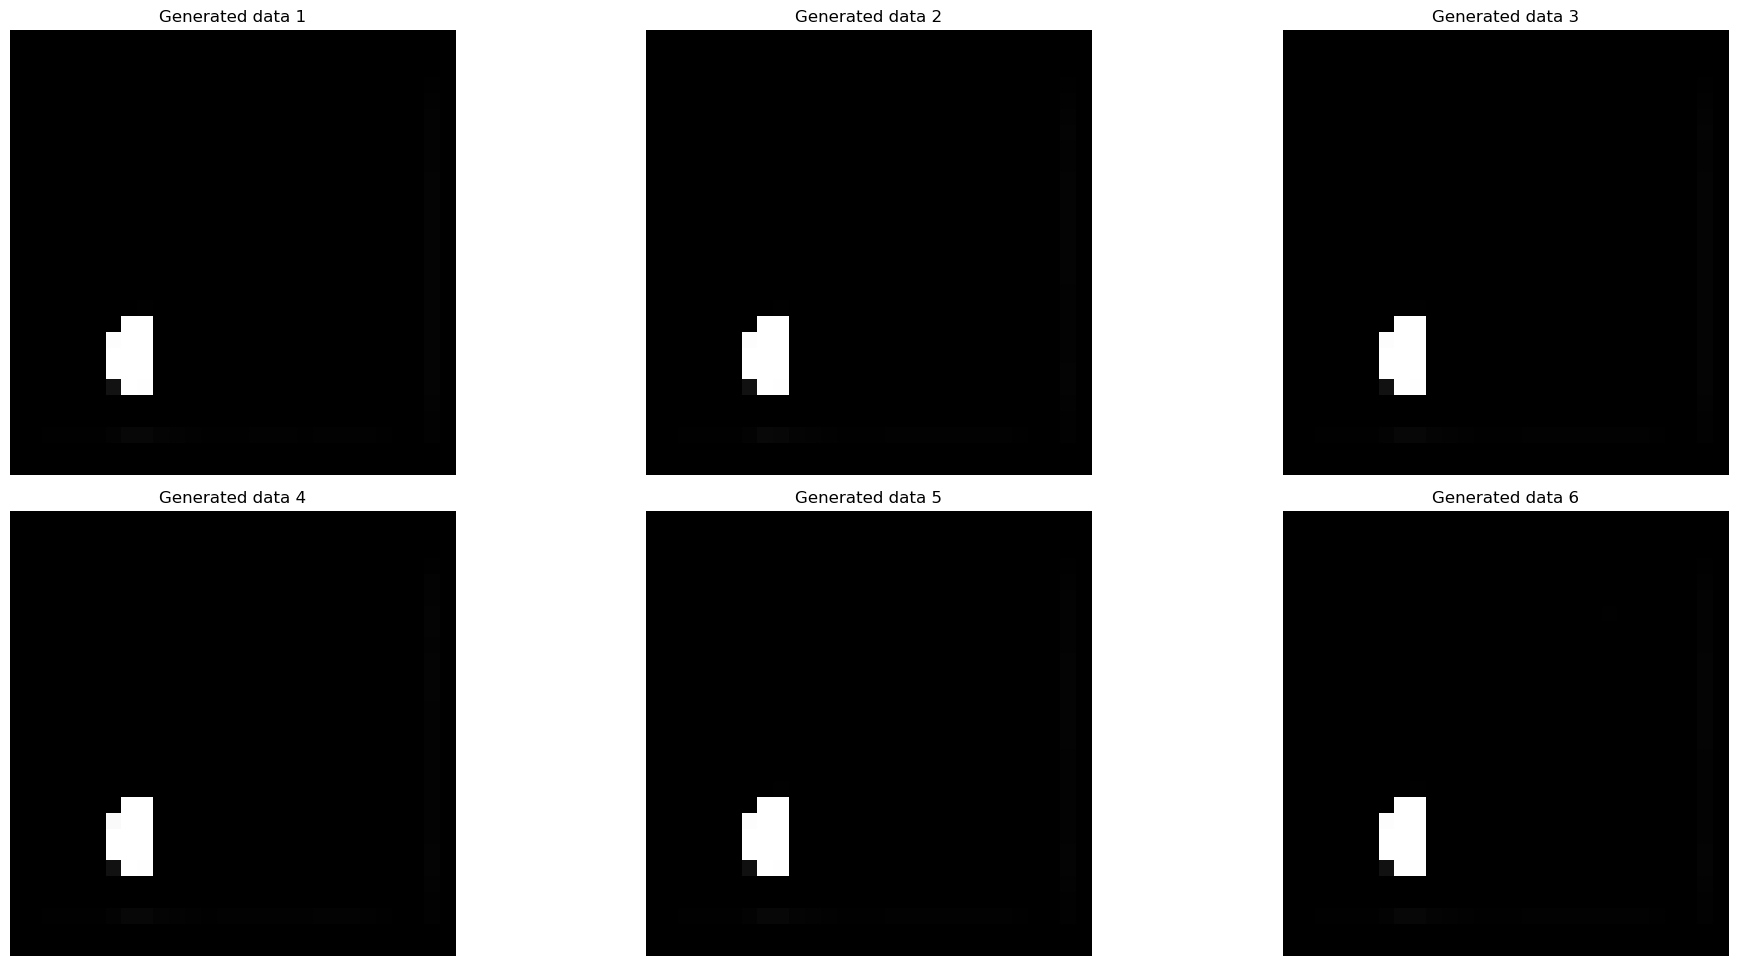

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 1719/1719 [10:31<00:00,  2.72it/s, loss=6.23, v_num=5]


In [19]:
trainer = pl.Trainer(max_epochs=15, gpus = 1, accelerator = 'mps')
trainer.fit(gan, train_loader)